<a href="https://colab.research.google.com/github/xoxonut/nycu-cv-113-2/blob/main/CV_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!tar -xvzf "/content/drive/MyDrive/hw1-data.tar.gz" -C "/content" > /dev/null 2>&1
!du -sh "/content/data"
!awk 'BEGIN {sum=0} /^[0-9]+$/ {sum+=$1} END {print sum}' <(find "/content/data/train" -type f | wc -l) <(find "/content/data/val" -type f | wc -l)

6.5G	/content/data
21024


In [26]:
from torchvision import transforms, datasets
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import DataLoader,Dataset
from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import numpy as np


In [55]:
def get_transforms():
  train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return train_transform,test_transform


In [56]:
def create_dataloader(train_transform,test_transform,batch_size):
  train_set = datasets.ImageFolder("/content/data/train",transform=train_transform)
  val_set = datasets.ImageFolder("/content/data/val",transform=test_transform)
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

  class TestDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
      self.root_dir = root_dir
      self.transform = transform
      valid_exts = (".jpg",".jpeg",".png",".bmp")
      self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(valid_exts)]

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, index):
      image_path = self.image_paths[index]
      image = Image.open(image_path).convert("RGB")
      if self.transform:
        image = self.transform(image)
      file_name = os.path.basename(image_path)
      name_only = os.path.splitext(file_name)[0]
      return image,name_only
  test_set = TestDataSet("/content/data/test",transform=test_transform)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader,val_loader,test_loader

In [57]:
def train_one_epoch(model,train_loader,optimizer,criterion,device):
  model.train()
  total_loss, correct, total = 0, 0, 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    predicted = torch.argmax(outputs, dim=1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
  avg_loss = total_loss / len(train_loader)
  avg_acc = correct / total * 100
  return avg_loss, avg_acc

In [58]:
def validate(model,val_loader,criterion,device):
  model.eval()
  total_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  avg_loss = total_loss / len(val_loader)
  avg_acc = correct / total * 100
  return avg_loss, avg_acc

In [59]:
def test_model(model,test_loader,device):
  model.eval()
  correct, total = 0, 0
  predictions = []
  with torch.no_grad():
    for inputs, file_names in test_loader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      preds = torch.argmax(outputs, dim=1)

      for file_name, pred in zip(file_names, preds):
        predictions.append({"image_name": file_name,
                            "pred_label": pred.item()})
  return predictions


In [60]:
# def init_RestNet50(num_classes):
#   model = torch.load("/content/drive/MyDrive/full_model.pth")
#   return model
def init_RestNet50(num_classes):
  model = resnet50(weights=ResNet50_Weights.DEFAULT)
  num_ftrs = model.fc.in_features
  model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
  )
  for p in model.parameters():
    p.requires_grad = False
  for p in model.fc.parameters():
    p.requires_grad = True
  for p in model.layer4.parameters():
    p.requires_grad = True
  return model
# class TenCropResNet50_3D(nn.Module):
#   def __init__(self,num_classes):
#     super(TenCropResNet50_3D,self).__init__()
#     self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
#     num_ftrs = self.resnet50.fc.in_features
#     self.resnet50.fc = nn.Sequential(
#       nn.Linear(num_ftrs, 512),
#       nn.ReLU(),
#       nn.Dropout(0.5),
#       nn.Linear(512, num_classes)
#     )
#     for param in self.resnet50.parameters():
#       param.requires_grad = True


In [61]:

import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [62]:
def print_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())  # in bytes
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())  # in bytes
    total_size = (param_size + buffer_size) / (1024 ** 2)  # Convert to MB
    print(f"Model size: {total_size:.2f} MB")


Model size: 94.08 MB
Epoch 1/5 - Train Loss: 1.7424 - Train Acc: 57.21% - Val Loss: 1.5380 - Val Acc: 59.33%
Epoch 2/5 - Train Loss: 0.7489 - Train Acc: 79.43% - Val Loss: 1.0583 - Val Acc: 71.33%
Epoch 3/5 - Train Loss: 0.4734 - Train Acc: 86.47% - Val Loss: 1.1029 - Val Acc: 74.67%
Epoch 4/5 - Train Loss: 0.3383 - Train Acc: 90.02% - Val Loss: 1.0426 - Val Acc: 78.33%
Epoch 5/5 - Train Loss: 0.2576 - Train Acc: 92.33% - Val Loss: 1.0420 - Val Acc: 74.33%


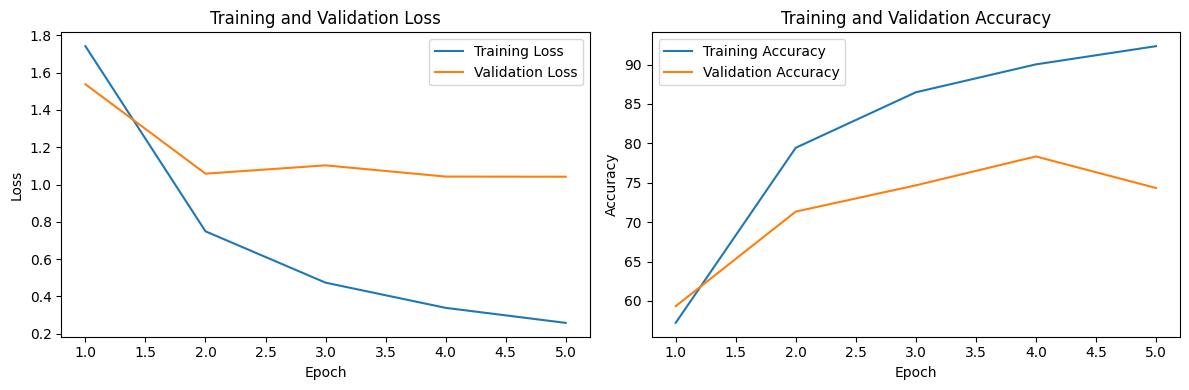

In [63]:
if __name__ == "__main__":
  train_transform,test_transform = get_transforms()
  train_loader,val_loader,test_loader = create_dataloader(train_transform,test_transform,32)
  model = init_RestNet50(100)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.01)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
  epochs = 5
  train_losses, train_accs, val_losses, val_accs = [], [], [], []
  print_model_size(model)
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    torch.save(model,"/content/drive/MyDrive/full_model.pth")
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
  plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)
  res = test_model(model,test_loader,device)
  df = pd.DataFrame(res)
  df.to_csv("/content/drive/MyDrive/prediction.csv",index=False)
